In [1]:
from compute import Var, eqvar, ureg, get_unit, buildidpvars, coupled_run, Evaluable, args_in_order, fill_args, unit_conversion_factors
from inputresolver import reassigneq, eqvars, eqsonly, default_out, mdf_order, default_in, idx_eqlist
from inputresolver import getallvars, invert_edges, resolve, reassign, flatten_order
from representations import bipartite_repr, drawbipartite, digraph_repr, draw, draw_dsm, tree_dsm
from compute_utils import get_outputs, check_eqs, print_out
from pprint import pprint
import networkx as nx
import sympy as sp
from sympy.utilities.lambdify import implemented_function
import numpy as np
from scipy import interpolate
import openmdao.api as om
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
z_table = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40])*1e3
T_table_celsius = np.array([15, 8.5,2,-4.49,-10.98,-17.47,-23.96,-30.45,-36.94,-43.42,-49.9,-56.5,-56.5,-51.6,-46.64,-22.8])
T_table = ureg.Quantity(T_table_celsius, 'degC').to('K').magnitude
G_table = np.array([9.807,9.804,9.801,9.797,9.794,9.791,9.788,9.785,9.782,9.779,9.776,9.761,9.745,9.73,9.715,9.684])
P_table = np.array([10.13,8.988,7.95,7.012,6.166,5.405,4.722,4.111,3.565,3.08,2.65,1.211,0.5529,0.2549,0.1197,0.0287])*1e4
ρ_table = np.array([1.225,1.112,1.007,0.9093,0.8194,0.7364,0.6601,0.59,0.5258,0.4671,0.4135,0.1948,0.08891,0.04008,0.01841,0.003996])
Tinterp = interpolate.interp1d(z_table, T_table)
Ginterp = interpolate.interp1d(z_table, G_table)
Pinterp = interpolate.interp1d(z_table, P_table)
ρinterp = interpolate.interp1d(z_table, ρ_table)

In [3]:
m_parafoil = Var('mv', 500., 'kg',never_output=True)
m_vhc = Var('mp', 4624, unit='kg', never_output=True)
m_lg = Var('m_l', unit='kg')
m_b = Var('m_b', unit='kg')
m_tot = Var('m_t', unit='kg')
eq0 = (m_tot, m_vhc+m_parafoil+m_lg+m_b)
rho0 = Var('rho0', ρinterp(0), 'kg/m^3', never_output=True)
T0 = Var('T0', Tinterp(0), 'K', never_output=True)
P0 = Var('P0', Pinterp(0), 'Pa', never_output=True)
G0 = Var('G0', Ginterp(0), 'm/s^2', never_output=True)
k = Var('k', 1.38064852e-23, 'J/K', never_output=True)
mm_He = Var('mm_He', 6.64e-27, 'kg', never_output=True)
mm_H2 = Var('mm_H2', 1.66e-27, 'kg', never_output=True)
C_D = Var('C_D', 0.47, never_output=True)
alpha = Var('a', 1, never_output=True)
v_rise = Var('v', 6, 'm/s', never_output=True)
r0 = Var('r0', unit='m')
A0, eq5 = eqvar('A0', np.pi*r0**2)
V0, eq6 = eqvar('V0', 4/3*np.pi*r0**3)
rho_LG0, eq7 = eqvar('rho_LG0', P0*(alpha*mm_He+(1-alpha)*mm_H2)/(k*T0))
eq8 = (m_lg, V0*rho_LG0)
L0, eq9 = eqvar('L0', rho0*V0*G0)
W0, eq10 = eqvar('W0', m_tot*G0)
D0, eq11 = eqvar('D0', 1/2*C_D*rho0*v_rise**2*A0)
R1, eq12 = eqvar('R1', L0-D0-W0)
R1.varval = 0

In [4]:
z = 30e3
rhoval = Var('rhoval', ρinterp(z), 'kg/m^3', never_output=True)
pval = Var('pval', Pinterp(z), 'Pa', never_output=True)
Tval = Var('Tval', Tinterp(z), 'K', never_output=True)
gval = Var('gval', Ginterp(z), 'm/s^2', never_output=True)
rz = Var('r_z', unit='m')
hz, eq13 = eqvar('h_z', 2*(3/2)*rz)
Vz, eq14 = eqvar('V_z', 4/3*np.pi*rz**3)
rho_LGz, eq15 = eqvar('rho_LGz', pval*(alpha*mm_He+(1-alpha)*mm_H2)/(k*Tval))
R2, eq16 = eqvar('R2', m_lg-Vz*rho_LGz) #needs to have same mass as balloon at STP
R2.varval = 0

In [5]:
t_LLDPE = Var('tL', 25.4e-6*1, 'm', never_output=True)
rho_LLDPE = Var('rhoL', 925, 'kg/m^3', never_output=True)
p = Var('p', 1.6, never_output=True) #some parameter
S, eq20 = eqvar('S', 4*np.pi*((rz**(2*p)+2*rz**p*(hz/2)**p)/3)**(1/p))
eq21 = (m_b, 2*(3/2)*S*t_LLDPE*rho_LLDPE)

In [6]:
eq_list = [eq0, eq5, eq6, eq7, eq8, eq9, eq10, eq11, eq12, eq13, eq14, eq15, eq16, eq20, eq21]

In [7]:
eqs = idx_eqlist(eq_list)
eqv = eqvars(eqs)
dins = default_in(eqs)
dout = default_out(eqs)

In [8]:
{elt for elt in dins if not elt.never_output}

{r0, r_z}

In [9]:
force_input = [R1, R2]
not_input = [r0, rz]

In [10]:
new_ins = dins.union(force_input) - set(not_input)
# new_eqv = {key: {elt for elt in outsetposs if not elt.never_output}
#         for key, outsetposs in eqv.items()}
new_eqv = {key: {elt for elt in outsetposs if not elt in new_ins}
        for key, outsetposs in eqv.items()}

In [11]:
new_eqv[13] = {S}

In [12]:
#new_eqv[13] = {S}

In [13]:
new_eqv

{0: {m_b, m_l, m_t},
 1: {A0, r0},
 2: {V0, r0},
 3: {rho_LG0},
 4: {V0, m_l, rho_LG0},
 5: {L0, V0},
 6: {W0, m_t},
 7: {A0, D0},
 8: {D0, L0, W0},
 9: {h_z, r_z},
 10: {V_z, r_z},
 11: {rho_LGz},
 12: {V_z, m_l, rho_LGz},
 13: {S},
 14: {S, m_b}}

In [51]:
BG, edges_original = bipartite_repr(new_eqv)
M = nx.bipartite.maximum_matching(BG)
newdout = {key:M[key] for key in dout.keys()}

In [15]:
newdout={0: m_tot,
 1: r0,
 2: V0,
 3: rho_LG0,
 4: m_lg,
 5: L0,
 6: W0,
 7: A0,
 8: D0,
 9: hz,
 10: rz,
 11: rho_LGz,
 12: Vz,
 13: S,
 14: m_b}

In [52]:
eqv_noparams = {elt:{key for key in keys if not key.never_output} for elt,keys in eqv.items()}

In [53]:
eqv_noparams = {elt:{key for key in keys if not key.never_output} for elt,keys in eqv.items()}
DG, edges = digraph_repr(eqv_noparams, newdout, intermediary=False)

In [54]:
list(nx.simple_cycles(DG))

[[m_b, m_t, W0, D0, A0, r0, V0, m_l, V_z, r_z, S],
 [m_b, m_t, W0, D0, A0, r0, V0, m_l, V_z, r_z, h_z, S],
 [W0, D0, A0, r0, V0, m_l, m_t],
 [V0, L0, D0, A0, r0]]

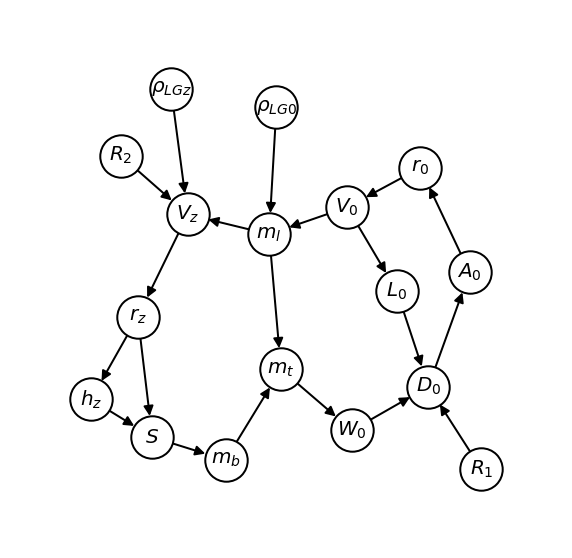

In [55]:
fig, ax = draw(DG, figsize=(10,10), node_shape='o', prog='neato', node_size=1800)
plt.sca(ax)
plt.savefig('balloon', dpi=300, bbox_inches='tight')

In [119]:
new_order = mdf_order(eqv, newdout)
order_flattened = []
for elt in new_order:
    if type(elt)==tuple:
        order_flattened.extend(elt)
    else:
        order_flattened.append(elt)

In [120]:
new_order

[11, 3, (14, 6, 2, 9, 13, 12, 8, 1, 10, 0, 4, 5, 7)]

In [58]:
varns = [newdout[elt] for elt in new_order[2]];

In [59]:
A = [[1 if elt in eqv[key] else 0 for elt in varns] for key in new_order[2]]

In [60]:
print("[{}]".format(";\n".join([" ".join(map(str,elt)) for elt in A])))

[1 0 0 0 1 0 0 0 0 0 0 0 0;
0 1 0 0 0 0 0 0 0 1 0 0 0;
0 0 1 0 0 0 0 1 0 0 0 0 0;
0 0 0 1 0 0 0 0 1 0 0 0 0;
0 0 0 1 1 0 0 0 1 0 0 0 0;
0 0 0 0 0 1 0 0 0 0 1 0 0;
0 1 0 0 0 0 1 0 0 0 0 1 0;
0 0 0 0 0 0 0 1 0 0 0 0 1;
0 0 0 0 0 1 0 0 1 0 0 0 0;
1 0 0 0 0 0 0 0 0 1 1 0 0;
0 0 1 0 0 0 0 0 0 0 1 0 0;
0 0 1 0 0 0 0 0 0 0 0 1 0;
0 0 0 0 0 0 1 0 0 0 0 0 1]


In [61]:
perm = [5, 4, 12, 10, 9, 13, 14, 0, 6, 8, 7, 1, 2]
#np.array(A)[np.ix_(p,p)]

In [122]:
order_flattened = new_order[0:2]+ perm
new_order = new_order[0:2] + [([5, 4, 12, 10, 9, 13, 14, 0, 6, 8, 7, 1], 2)]

In [63]:
order_flattened

[11, 3, 5, 4, 12, 10, 9, 13, 14, 0, 6, 8, 7, 1, 2]

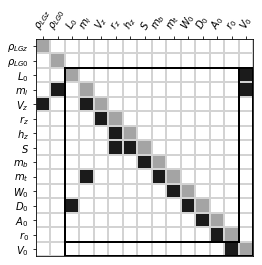

In [157]:
ax = draw_dsm(DG, order_flattened, newdout)
rect1 = patches.Rectangle((2,2), 13, 13, linewidth=2, edgecolor='k', facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle((2,2), 12, 12, linewidth=2, edgecolor='k', facecolor='none')
ax.add_patch(rect2)
plt.savefig('balloon_tear1.png', dpi=600, bbox_inches='tight')

In [65]:
new_eqs = reassign(eqs, newdout)

In [66]:
new_insfull = default_in(new_eqs)
[new_eqs[elt] for elt in order_flattened]

[(rho_LGz, pval*(a*mm_He + mm_H2*(1 - a))/(Tval*k)),
 (rho_LG0, P0*(a*mm_He + mm_H2*(1 - a))/(T0*k)),
 (L0, G0*V0*rho0),
 (m_l, V0*rho_LG0),
 (V_z, (-R2 + m_l)/rho_LGz),
 (r_z, 0.620350490899399*V_z**(1/3)),
 (h_z, 3.0*r_z),
 (S, 12.5663706143592*(r_z**(2*p)/3 + 2*r_z**p*(h_z/2)**p/3)**(1/p)),
 (m_b, 3.0*S*rhoL*tL),
 (m_t, m_b + m_l + mp + mv),
 (W0, G0*m_t),
 (D0, L0 - R1 - W0),
 (A0, 2.0*D0/(C_D*rho0*v**2)),
 (r0, 0.564189583547757*sqrt(A0)),
 (V0, 4.18879020478639*r0**3)]

In [67]:
new_insfull

{C_D,
 G0,
 P0,
 R1,
 R2,
 T0,
 Tval,
 a,
 k,
 mm_H2,
 mm_He,
 mp,
 mv,
 p,
 pval,
 rho0,
 rhoL,
 tL,
 v}

In [134]:
prob = om.Problem()
model = prob.model
buildidpvars(new_insfull, model)
counter = coupled_run(new_eqs, new_order, (), model, model, debug=True)
prob.setup()

eq11 rho_LGz pval*(a*mm_He + mm_H2*(1 - a))/(Tval*k) None
eq3 rho_LG0 P0*(a*mm_He + mm_H2*(1 - a))/(T0*k) None
eq5 L0 G0*V0*rho0 None
eq4 m_l V0*rho_LG0 None
eq12 V_z (-R2 + m_l)/rho_LGz None
eq10 r_z 0.620350490899399*V_z**(1/3) None
eq9 h_z 3.0*r_z None
eq13 S 12.5663706143592*(r_z**(2*p)/3 + 2*r_z**p*(h_z/2)**p/3)**(1/p) None
eq14 m_b 3.0*S*rhoL*tL None
eq0 m_t m_b + m_l + mp + mv None
eq6 W0 G0*m_t None
eq8 D0 L0 - R1 - W0 None
eq7 A0 2.0*D0/(C_D*rho0*v**2) None
eq1 r0 0.564189583547757*sqrt(A0) None
eq2 V0 4.18879020478639*r0**3 None


In [138]:
new_order

[11, 3, ([5, 4, 12, 10, 9, 13, 14, 0, 6, 8, 7, 1], 2)]

In [194]:
prob.set_val('mp', 4545)
#prob.set_val('m_b', 3078.8)
# prob.set_val('m_l',1397.)
#prob.set_val('D0', 5000)
# prob.set_val('L0', 99300)
# prob.set_val('r0', 13)
# prob.set_val('m_t', 9500)
# prob.set_val('r_z', 50)
# prob.set_val('A0', 500)
# prob.set_val('S', 43680)
# prob.set_val('V_z', 500)
prob.set_val('V0', 7516)
# prob.set_val('h_z', 151.8)
# prob.set_val('W0', 92942.749)
#prob.run_model()

In [195]:
prob.run_model()

rho_LGz [0.00254151]
rho_LG0 [0.16907359]

group1.group2
L0 [90294.0297]
m_l [1270.75708733]
V_z [500000.9419929]
r_z [49.23728201]
h_z [147.71184604]
S [41006.68648835]
m_b [2890.35629713]
m_t [9206.11338446]
W0 [90284.35396138]
D0 [9.67573862]
A0 [0.93363619]
r0 [0.54514735]
V0 [0.67862572]
L0 [8.15272097]
m_l [0.11473769]
V_z [500000.9419929]
r_z [49.23728201]
h_z [147.71184604]
S [41006.68648835]
m_b [2890.35629713]
m_t [9206.11338446]
W0 [90284.35396138]
D0 [9.67573862]
A0 [0.93363619]
r0 [0.54514735]
V0 [0.67862572]
L0 [-425439.47495503]
m_l [-5987.44158195]
V_z [-2355860.50312781]
r_z [nan]
h_z [nan]
S [nan]
m_b [nan]
m_t [nan]
W0 [nan]
D0 [nan]
A0 [nan]
r0 [nan]
V0 [nan]
L0 [nan]
m_l [nan]
V_z [-2355860.50312781]
r_z [nan]
h_z [nan]
S [nan]
m_b [nan]
m_t [nan]
W0 [nan]
D0 [nan]
A0 [nan]
r0 [nan]
V0 [nan]
NL: NewtonSolver 'NL: Newton' on system 'group1.group2': residuals contain 'inf' or 'NaN' after 1 iterations.


## Solution

In [75]:
model.list_outputs();

34 Explicit Output(s) in 'model'

varname      val              
-----------  -----------------
inp
  mm_He      [6.64e-27]       
  p          [1.6]            
  R2         [0.]             
  Tval       [226.51]         
  mp         [4545.]          
  G0         [9.807]          
  T0         [288.15]         
  mv         [500.]           
  mm_H2      [1.66e-27]       
  v          [6.]             
  R1         [0.]             
  k          [1.38064852e-23] 
  C_D        [0.47]           
  rhoL       [925.]           
  rho0       [1.225]          
  a          [1.]             
  P0         [101300.]        
  pval       [1197.]          
  tL         [2.54e-05]       
group1
  eq11
    rho_LGz  [0.00254151]     
  eq3
    rho_LG0  [0.16907359]     
  group2
    eq5
      L0     [98025.42527999] 
    eq4
      m_l    [1379.56523069]  
    eq12
      V_z    [542813.35257814]
    eq10
      r_z    [50.60428632]    
    eq9
      h_z    [151.81285896]   
    eq13
      S      [